# Diffusers による事前学習済み DDPM からの画像生成

## ライブラリのインストール

In [1]:
!pip install diffusers==0.11.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## ライブラリのインポート

In [2]:
# ログ表示・画像表示等
import tqdm # プログレスバーの表示
import PIL.Image # 画像の表示
import numpy as np # NumPy

# PyTorch
import torch

# Diffusers 関連
from diffusers import (DDPMPipeline, # 事前学習済みモデルの読み込み等
                       UNet2DModel, # U-Net
                       DDPMScheduler) # 生成におけるステップ数の管理

## 事前学習済みモデルの読み込みと画像生成

In [3]:
# DDPM の事前学習済みモデル（顔画像）を読み込む
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")

# 事前学習済みモデルを GPU に転送
image_pipe.to("cuda")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.11.1",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [4]:
# 事前学習済みモデルを使って、画像 1,000 枚を生成
images = image_pipe().images

  0%|          | 0/1000 [00:00<?, ?it/s]

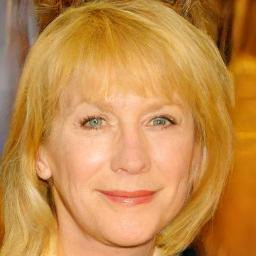

In [5]:
# 1 枚目の画像を表示
images[0]

## 事前学習済みモデルを使って、手動での画像生成

In [6]:
# 読み込む事前学習済みモデル（教会）の名称
repo_id = "google/ddpm-church-256"

# DDPM 用に事前学習された U-Net を取得
model = UNet2DModel.from_pretrained(repo_id)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [7]:
# U-Net の中身を確認
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [8]:
# 学習時の設定を確認
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('act_fn', 'silu'),
            ('attention_head_dim', None),
            ('norm_num_groups', 32),
            ('norm_eps', 

In [9]:
# スケジューラ（学習時の初期ノイズの大きさなど）を取得
scheduler = DDPMScheduler.from_config(repo_id)

In [10]:
# スケジューラの中身を確認
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.1.1')])

In [11]:
# 画像を表示する関数
def display_sample(sample, # 画像の PyTorch 配列
                   i # タイムステップ
                   ):
    # 画像の PyTorch 配列を CPU に転送し、(データ数, 縦, 横, チャンネル) 形式に次元を並び替える
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    # [0 ~ 1]の整数値なので、[0 ~ 255]の範囲になるように変換
    image_processed = (image_processed + 1.0) * 127.5
    # 範囲を変換した画像を uint8 (符号なし 8 bit 整数) 型に変更
    image_processed = image_processed.numpy().astype(np.uint8)

    # 画像の配列を PIL 形式に変換
    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}") # タイムステップを表示
    display(image_pil) # PIL 形式にした画像を表示

In [14]:
# タイムステップ（= 変換回数）を 1,000 回に指定（学習は 1,000 回）
scheduler.set_timesteps(num_inference_steps=1000)

 10%|▉         | 99/1000 [00:11<01:48,  8.30it/s]

'Image at step 100'

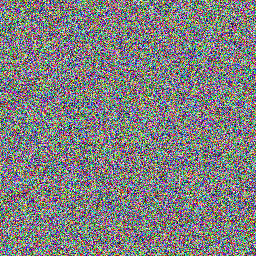

 20%|█▉        | 199/1000 [00:24<01:36,  8.34it/s]

'Image at step 200'

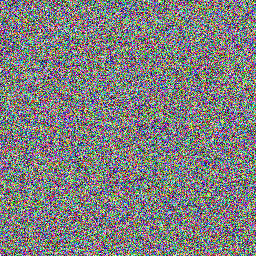

 30%|██▉       | 299/1000 [00:36<01:24,  8.25it/s]

'Image at step 300'

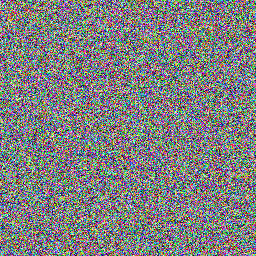

 40%|███▉      | 399/1000 [00:48<01:11,  8.41it/s]

'Image at step 400'

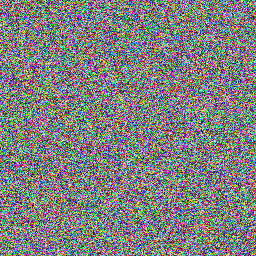

 50%|████▉     | 499/1000 [01:00<00:59,  8.42it/s]

'Image at step 500'

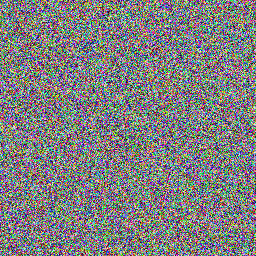

 60%|█████▉    | 599/1000 [01:12<00:47,  8.43it/s]

'Image at step 600'

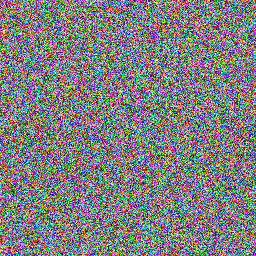

 70%|██████▉   | 699/1000 [01:24<00:35,  8.37it/s]

'Image at step 700'

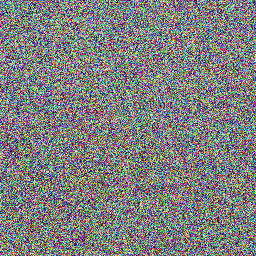

 80%|███████▉  | 799/1000 [01:36<00:24,  8.27it/s]

'Image at step 800'

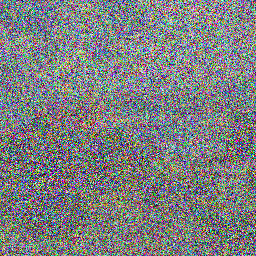

 90%|████████▉ | 899/1000 [01:48<00:12,  8.33it/s]

'Image at step 900'

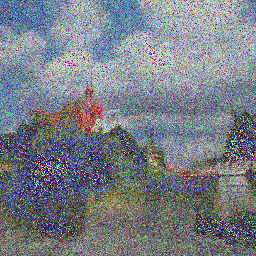

100%|█████████▉| 999/1000 [02:00<00:00,  8.32it/s]

'Image at step 1000'

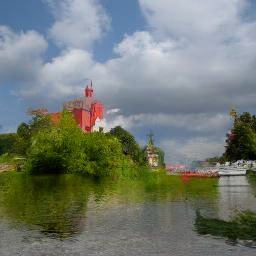

100%|██████████| 1000/1000 [02:00<00:00,  8.29it/s]


In [15]:
# 結果を固定するための seed 値
torch.manual_seed(0)
# 最初の標準正規分布に従う乱数を生成
noisy_sample = torch.randn(
    1, # データ数
    model.config.in_channels, # チャンネル数（= 3）
    model.config.sample_size, # 縦 (= 256)
    model.config.sample_size # 横 (= 256)
)

# 事前学習済み U-Net を GPU に転送
model.to("cuda")

# 最初の乱数を GPU に転送
noisy_sample = noisy_sample.to("cuda")

# 乱数を sample という名前にする
sample = noisy_sample

# 指定したタイムステップ分、ノイズ除去の変換を行う
for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # U-Net からの出力を得る
  with torch.no_grad():
        # 差分部分を出力
        residual = model(sample, # 入力（= ノイズ画像）
                       t # タイムステップ
                       ).sample # 差分を取得

  # U-Net から出力した差分と、入力を使って、ノイズ除去後の画像を取得
  sample = scheduler.step(residual, # 差分
                          t, # タイムステップ
                          sample # 入力
                          ).prev_sample # 除去後の画像を取得

  # 100 ステップごとに画像を出力
  if (i + 1) % 100 == 0:
      display_sample(sample, i + 1)